# Optical Character Recognition of Arabic Characters

Classifiying Arabic characters. For more details please visit [this link](https://www.kaggle.com/mloey1/ahdd1)

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

### Loading training dataset

In [2]:
# load training data
x_train = pd.read_csv('./dataset/csvTrainImages 13440x1024.csv')
print("Training images")
x_train.head()

# load training labels
y_train = pd.read_csv('./dataset/csvTrainLabel 13440x1.csv')
print("Training labels")
y_train.head()

# convert x_train dataframe to numpy ndarray and transpose each image using swapaxes.
x_train = x_train.values.reshape([-1,32,32]).swapaxes(1,2)

# convert y_train dataframe to numpy ndarray and remove all extra dimensions.
y_train = y_train.values.squeeze()

Training images
Training labels


### Loading test dataset

In [3]:
valid_test_split = 0.5

# load test data
x_test = pd.read_csv('./dataset/csvTestImages 3360x1024.csv')
x_test.head()
x_test = x_test.values.reshape([-1,32,32]).swapaxes(1,2)

# load test labels
y_test = pd.read_csv('./dataset/csvTestLabel 3360x1.csv')
y_test.head()
y_test = y_test.values.squeeze()

### Creating validation and test splits of the test set

In [4]:
m_test = y_test.shape[0]
x_val = x_test[ : int(m_test * valid_test_split) ]
x_test = x_test[ int(m_test * valid_test_split) : ]

y_val = y_test[ : int(m_test * valid_test_split) ]
y_test = y_test[ int(m_test * valid_test_split) : ]

print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)


x_train shape: (13439, 32, 32)
x_val shape: (1679, 32, 32)
x_test shape: (1680, 32, 32)
y_train shape: (13439,)
y_val shape: (1679,)
y_test shape: (1680,)


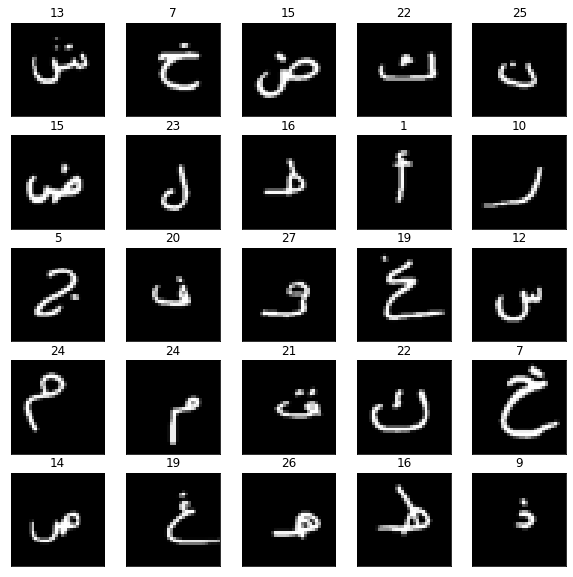

In [5]:
fig = plt.figure(0, figsize=(10,10))
indices = np.random.randint(0, y_train.shape[0], size=25)


for i, idx in enumerate(indices):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(str(y_train[idx]))
    plt.xticks([])
    plt.yticks([])
plt.show()

### Preprcoessing

In [6]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

In [14]:
x_train = x_train[:,:,:,None]
x_val = x_val[:,:,:,None]
x_val = x_val[:,:,:,None]

In [7]:
from sklearn.preprocessing import OneHotEncoder

one_hot = OneHotEncoder()
y_train = one_hot.fit_transform(y_train[:, None]).toarray()
y_val = one_hot.fit_transform(y_val[:, None]).toarray()
y_test = one_hot.fit_transform(y_test[:, None]).toarray()

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(13439, 28)
(1679, 28)
(1680, 28)


/home/osama/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/osama/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


### Building the classification model

In [34]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout

In [36]:
classifier = Sequential()
classifier.add(Conv2D(16, 5, strides=1, padding='valid', activation='relu', input_shape=[32, 32, 1]))
classifier.add(BatchNormalization(axis=2))

classifier.add(Conv2D(32, 2, strides=2, padding='valid', activation='relu'))
classifier.add(BatchNormalization(axis=2))

classifier.add(Conv2D(64, 5, strides=1, padding='valid', activation='relu'))
classifier.add(BatchNormalization(axis=2))

classifier.add(Conv2D(128, 2, strides=2, padding='valid', activation='relu'))
classifier.add(BatchNormalization(axis=2))

classifier.add(GlobalAveragePooling2D())

classifier.add(Dropout(rate=0.2))
classifier.add(Dense(128, activation='relu'))
classifier.add(BatchNormalization(axis=1))

classifier.add(Dropout(rate=0.2))
classifier.add(Dense(28, activation='softmax'))

classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 28, 28, 16)        416       
_________________________________________________________________
batch_normalization_21 (Batc (None, 28, 28, 16)        112       
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 14, 14, 32)        2080      
_________________________________________________________________
batch_normalization_22 (Batc (None, 14, 14, 32)        56        
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
batch_normalization_23 (Batc (None, 10, 10, 64)        40        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 5, 5, 128)         32896     
__________

In [ ]:
# training
from keras.callbacks import ModelCheckpoint
chkpt = ModelCheckpoint('arabic_ocr_best_weights.md5', verbose=1, save_best_only=True)

classifier.fit(x_train,
               y_train,
               batch_size=512,
               epochs=5,
               verbose=2,
               validation_data=(x_val, y_val),
               callbacks=chkpt)

In [ ]:
classifier.evaluate(x_test, y_test)